Question 1:

Dans l'énoncé il est écrit de prendre $a=0$ mais dans le cours c'est définit que pour $a>0$ donc j'ai pris $a=1$. De plus je n'ai pas réussi à installer R sur mon mac...et il n'y a pas (du moins je n'ai pas trouvé) d'équivalent de fonction tcplot qui pourrait me permettre de choisir le bon treshold. Voici les lignes de code de la question 1 que j'ai codé en R :
$$
library(extRemes)
# Généreration des données
n <- 1e5
alpha <- 3
b <- 1
a <- 1
r_data <- rFrechet(n, loc = b, scale = a, shape = alpha)
# Utiliser la fonction tcplot pour explorer les seuils
tcplot(r_data, xlab = "Threshold", main = "Threshold Choice Plot")
$$

Supposons que cet algo fonctionne en R. Il me renverrai un graphe sur le quel je devrais choisir une valeur de x (le tresholde)

---

comprise entre a et b où a et b sont tels qu'entre ces valeurs la fonction mrl est quasi-linéaire.

On va afficher le plot de stabilité comme dans le cours (figure 2.3 Page 29) et on va regarder pour quels $x$ les deux courbes sont localements constantes. On choisir $x$ de telle sorte et $x=treshold$.

In [19]:
import numpy as np
from scipy.stats import genpareto
from scipy.stats import genextreme

#Pour répondre à la question 4 il suffit de changer les valeurs des paramètres ci desssous.
n = 10000
alpha = 3
b = 0
a = 1

# On utilise la methode inverse pour générer l'échantillon de données
#Si on ne génère pas les données par cette méthode l'algo suivant rend un stability plot pas joli du tout...
u = np.random.rand(n)
data = b - a * (-np.log(u)) ** (1/alpha) #on garde ces valeurs dans toute la suite.

def fit_gpd(data, threshold):
    data_sup = data[data > threshold]

    if len(data_sup) == 0:
        return (np.nan, np.nan)  # Si jamais y a aucun points au dessus du treshold.(sans cette exception ca bug...)

    pareto_fit = genpareto.fit(data_sup - threshold)
    gamma_hat, sigma_hat = pareto_fit[0], pareto_fit[1]
    return sigma_hat, gamma_hat

# Stability plot à la main
def stability_plot(data, n_points=100):
    thresholds = np.linspace(min(data), max(data), n_points)
    sigma_parameters = []
    gamma_parameters = []

    for t in thresholds:
        sigma_hat, gamma_hat = fit_gpd(data, t)
        sigma_parameters.append(sigma_hat)
        gamma_parameters.append(gamma_hat)

    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()

    ax1.plot(thresholds, sigma_parameters, label=" (σ)", color='b')
    ax2.plot(thresholds, gamma_parameters, label="(γ)", color='r')

    ax1.set_xlabel("(t)")
    ax1.set_ylabel("(σ)", color='b')
    ax2.set_ylabel("(γ)", color='r')

    plt.title("Stability Plot")

    plt.show()


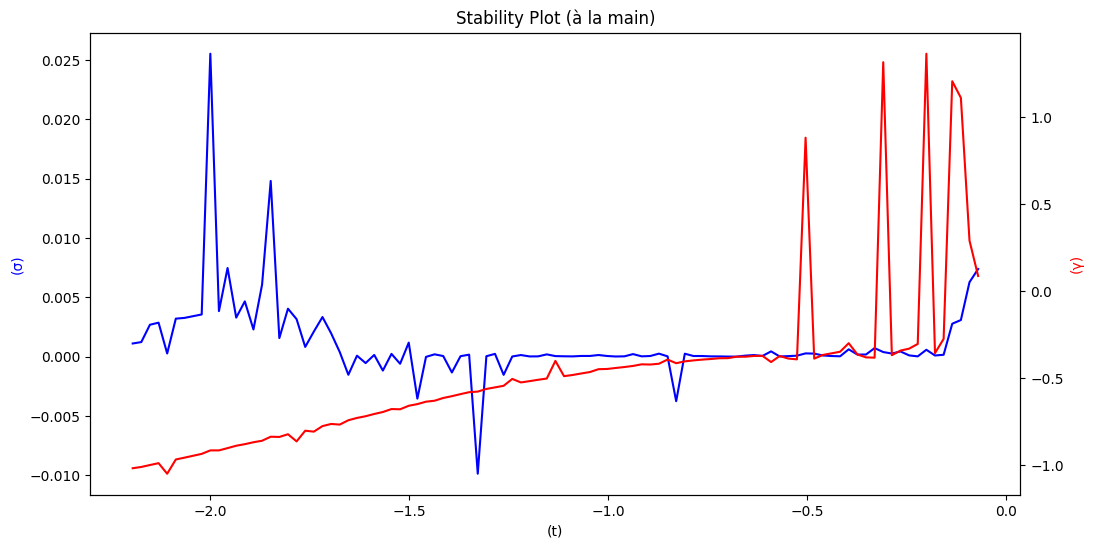

In [20]:
stability_plot(data,100)

On choisit donc $treshold=-0.7.$

Question 2


In [7]:

threshold = - 0.7 #Choisi par le stability plot

#estimation des paramètres
sigma_hat, gamma_hat = fit_gpd(data, threshold)

# Estimation de ζ
data_sup= data[data > threshold]
estimated_zeta = len(data_sup) / len(data)

#  Valeur desirée (1 - 5.10^(-4))
quantile_niveau = 1 - 5*10**(-4)

# Calculate the quantile using the estimated GPD parameters and ζ
quantile = threshold + (sigma_hat / gamma_hat) * ((quantile_niveau ** (-gamma_hat)) - 1)

print(f" La valeur estimée au niveau {quantile_niveau} est : {quantile}")

 La valeur estimée au niveau 0.9995 est : -0.4899999456946667


Question 3 :


In [21]:
import numpy as np
from scipy.stats import genpareto

# Parametres
Nexpe = 100
n = int(1e5)
true_quantile = 0.9
threshold = -0.7

quantile_estimates = np.zeros(Nexpe)
true_quantile_in_range = np.zeros(Nexpe)

for i in range(Nexpe):
    # Choisi les valeurs au dessus du threshold
    data_above_threshold = data[data > threshold]

    # On Fit
    params = genpareto.fit(data_above_threshold, floc=threshold)

    # Estime le quantile
    quantile_estimates[i] = genpareto.ppf(true_quantile, *params)

#Calcul des bornes
alpha = 0.1
lower_percentile = np.percentile(quantile_estimates, 100 * alpha*0.5)
upper_percentile = np.percentile(quantile_estimates, 100 * (1 - alpha*0.5))

# Check if the true quantile is in the interquantile range
true_quantile_in_range = lower_percentile <= true_quantile <= upper_percentile

# Compute the mean squared error
mse = np.mean((quantile_estimates - true_quantile) ** 2)

print(f"Empirical Interquantile Range: ({lower_percentile}, {upper_percentile})")
print(f"True Quantile in Range: {true_quantile_in_range}")
print(f"Mean Squared Error: {mse}")


Empirical Interquantile Range: (-0.3076085515835898, -0.3076085515835898)
True Quantile in Range: False
Mean Squared Error: 1.4583184138578165


Question 4 :

On rend le calcul précédent fonctionnelle (en fonction de $\alpha$) et ensuite on affiche les différentes valeurs.

Pour $mse(\alpha=1.1)=280$ et $mse(\alpha=10)=5$ donc plus la valeur de $\alpha$ augmente et plus la valeur de l'erreur quadratique diminue.


In [61]:
import numpy as np
from scipy.stats import genpareto

def calcule_mse(alpha, Nexpe=100, n=int(1e5), true_quantile=0.9, threshold=-5.0):
    u = np.random.rand(n)
    data = (-np.log(u)) ** (-1/alpha)

    quantile_estimates = np.zeros(Nexpe)

    for i in range(Nexpe):
        data_above_threshold = data[data > threshold]
        params = genpareto.fit(data_above_threshold, floc=threshold)
        quantile_estimates[i] = genpareto.ppf(true_quantile, *params)

    alpha = 0.1
    lower_percentile = np.percentile(quantile_estimates, 100 * alpha * 0.5)
    upper_percentile = np.percentile(quantile_estimates, 100 * (1 - alpha * 0.5))

    true_quantile_in_range = (lower_percentile <= true_quantile) and (true_quantile <= upper_percentile)

    mse = np.mean((quantile_estimates - true_quantile) ** 2)

    return mse


In [62]:
print(calcule_mse(1.1),calcule_mse(10))

280.37307567838377 5.089672187892377
